In [1]:
import os
import glob
import time
import heapq
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colormaps
import pickle
import torch
from tqdm import tqdm
import seaborn as sns
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from typing import Union
import networkx as nx

from env.graph_env import copy_graph, Indices, is_stable, in_table_index
from env.graph_env import create_graph_label_continuous, flatten_pos, unflatten_pos

In [2]:
OBJECT_SIZES = {
	0: (5, 5),
	1: (5, 5),
	2: (3, 3),
	3: (7, 7),
}

def copy_state(state):
	return {'graph': copy_graph(state['graph']), 'manipulator': state['manipulator'].clone()}

def is_empty_object(graph, node):
	return find_start_node(graph, node) is None

def is_edge_in_graph(graph, node1, node2):
	if graph.x[node1, Indices.RELATION.start + node2] == 0:
		return False
	return True

def is_in_env(coor, size, grid_size):
	if coor[0] - size[0]//2 < 0 or coor[0] + size[0]//2 >= grid_size[0]:
		return False
	if coor[1] - size[1]//2 < 0 or coor[1] + size[1]//2 >= grid_size[1]:
		return False
	return True

def find_target_node(graph, node):
	i = (graph.x[node, Indices.RELATION] == 1).nonzero(as_tuple=True)[0]
	if len(i):
		return i.item()
	return None

def find_start_node(graph, node):
	i = (graph.x[:, Indices.RELATION.start + node] == 1).nonzero(as_tuple=True)[0]
	if len(i):
		return i.item()
	return None

def find_base_node(graph, node):
	while graph.x[node, Indices.RELATION].sum() != 0:
		node = find_target_node(graph, node)
	return node

def find_occupying_nodes(table, coor, size):
	occupying_nodes = []
	unique_nodes = np.unique(table[in_table_index(coor, size)])
	for node in unique_nodes:
		if node == 0:
			continue
		occupying_nodes.append(node-1)

	return occupying_nodes

def get_obj_size(label):
	return OBJECT_SIZES[label]

def get_empty_objects(env, ref_node, n=1):
	all_objects = list(range(env.num_nodes))
	random.shuffle(all_objects)
	empty_objects = []
	for obj in all_objects:
		if is_empty_object(env.state_graph, obj) and is_stable(env.state_graph.x, ref_node, obj):
			empty_objects.append(obj)
			if len(empty_objects) >= n:
				break
	return empty_objects

def get_all_positions_of_object(coord, size):
    idx = in_table_index(coord, size)
    x_range = np.arange(idx[0].start, idx[0].stop)
    y_range = np.arange(idx[1].start, idx[1].stop)
    x, y = np.meshgrid(x_range, y_range, indexing='ij')
    return np.column_stack((x.ravel(), y.ravel()))

def get_all_positions_in_env(grid_size, size):
    x_range = np.arange(size[0] // 2, grid_size[0] - size[0] // 2)
    y_range = np.arange(size[1] // 2, grid_size[1] - size[1] // 2)
    x, y = np.meshgrid(x_range, y_range, indexing='ij')
    return np.column_stack((x.ravel(), y.ravel()))

def get_empty_positions(env, ref_node, n=1):
	all_positions = get_all_positions_in_env(env.grid_size, env.obj_size(ref_node))

	# Sample random positions instead of shuffling the entire list
	random_indices = random.sample(range(len(all_positions)), len(all_positions))
	sampled_positions = (all_positions[i] for i in random_indices)

	# Use a generator to find the first `n` unoccupied positions
	positions = []
	for position in sampled_positions:
		position = torch.tensor(position, dtype=torch.float32)
		if not env.is_coor_occupied(position, ref_node):
			positions.append(flatten_pos(position, env.grid_size))
			if len(positions) >= n:
				break

	return positions

def draw_dependency_graph(env):
	dependency_graph = nx.DiGraph()
	for k in range(env.num_nodes):
		dependency_graph.add_node(k)
		i = find_target_node(env.target_graph, k)
		if i is None:
			j = find_target_node(env.state_graph, k)
			Tk = env.target_graph.x[k, Indices.COORD]
			CK = env.state_graph.x[k, Indices.COORD]
			if torch.equal(CK, Tk):
				if j is not None:
					dependency_graph.add_edge(k, j)
					while env.state_graph.x[j, Indices.RELATION].sum() != 0:
						j = find_target_node(env.state_graph, j)
						if j is None:
							break
						dependency_graph.add_edge(k, j)
			else:
				size = env.get_obj_size(k)
				occupying_nodes = find_occupying_nodes(env.table, Tk, size)
				for j in occupying_nodes:
					if j != k:
						j = find_base_node(env.state_graph, j)
						# if the k,j pair is not in the dependency graph
						if not dependency_graph.has_edge(k, j):
							dependency_graph.add_edge(k, j)
		else:
			j = find_start_node(env.state_graph, i)
			if j is not None and j != k:
				dependency_graph.add_edge(k, j)

	fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
	nx.draw(dependency_graph, env.state_graph.pos, with_labels=True, node_size=400, ax=ax, node_color='skyblue')
	plt.title('Dependency Graph')
	plt.show()

def draw_manipulator_decoding(env):
	height_grid, width_grid = env.grid_size
	table = np.zeros(env.grid_size, dtype=int)
	for i in range(height_grid):
		for j in range(width_grid):
			table[i, j] = env.manipulator_decode([i, j])[0]
	plt.imshow(table, cmap='viridis')
	plt.show()

def evaluate_alg(env, alg, initial_graph, target_graph, **kwargs):
	env.reset(initial_graph, target_graph)
	start = time.time()
	print(f"--------{alg.__name__}--------")
	optimal_actions, steps = alg(env).solve(**kwargs)
	elapsed_time = time.time() - start
	print(f'optimal_actions: {optimal_actions} in {steps} steps')
	print(f'elapsed time: {elapsed_time:.2f}s')
	if optimal_actions is not None:
		env_cost(env, optimal_actions, initial_graph, target_graph)
	return optimal_actions

def env_cost(env, actions, initial_graph, target_graph, log=True):
	env.reset(initial_graph, target_graph)
	ep_cost = 0
	for action in actions:
		cost, _ = env.step_cost(action, log=log)
		ep_cost += cost
	if log:
		print(f'episode cost: {ep_cost:.3f}')
	env.reset(initial_graph, target_graph)
	return ep_cost

def positional_encode(one_hot_position):
	positions = torch.argmax(one_hot_position, dim=1)
	encodings = torch.zeros((len(positions), 1))

	for i, position in enumerate(positions):
		if torch.sum(one_hot_position[i]) == 0:
			encodings[i] = -1
		else:
			encodings[i] = position

	return encodings

def state_to_hashable(state):
	if hasattr(Indices, 'LABEL'):
		new_state = torch.cat([state['graph'].x[:, Indices.LABEL], state['graph'].x[:, Indices.COORD], positional_encode(state['graph'].x[:, Indices.RELATION])], dim=1)
	else:
		new_state = torch.cat([state['graph'].x[:, Indices.COORD], positional_encode(state['graph'].x[:, Indices.RELATION])], dim=1)
	return tuple(state['manipulator'].numpy().tolist() + new_state.view(-1).tolist())

def reconstruct_path(node):
    path = []
    while node.parent is not None:
        path.append(node.action)
        node = node.parent
    path.reverse()
    return path

def cal_density(env):
    phi = np.sum([env.get_obj_size(i)[0] * env.get_obj_size(i)[1] for i in range(env.num_nodes)])
    return phi / (env.grid_size[0] * env.grid_size[1])

def plot_graph(graph, grid_size, ax=None, fig_size=2.5, title=None, constraints=[]):
	if ax is None:
		fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size*(grid_size[1]/grid_size[0])))

	# Create a color grid based on the labels and the color dictionary
	color_by_label = {
		0: 'white',		# background
		1: 'yellow',
		2: 'orange',
		3: 'green',
		4: 'blue',
		5: 'red',		# manipulator
	}

	# Map the table values to colormap indices
	mapped_table = np.zeros(grid_size, dtype=int)
	unrendered_nodes = list(range(graph.num_nodes))
	while len(unrendered_nodes) > 0:
		i = unrendered_nodes.pop(0)
		label_i = graph.x[i, Indices.LABEL].item()
		coor = graph.x[i, Indices.COORD].numpy()
		size = get_obj_size(label_i)
		if graph.x[i, Indices.RELATION].sum() > 0:
			child = find_target_node(graph, i)
			if child in unrendered_nodes:
				unrendered_nodes.append(i)
				continue
			if label_i == 0 and graph.x[child, Indices.LABEL].item() == 2:
				size = (1, 1)
		mapped_table[in_table_index(coor, size)] = label_i + 1
	
	for i in range(len(constraints)):
		# if the type of constraints is tensor, convert it to int
		if isinstance(constraints[i], torch.Tensor):
			constraints = constraints[i].numpy()
		else:
			constraints = constraints[i]
		c_x, c_y = list(map(int, constraints))
		mapped_table[c_x, c_y] = 5

	# Create a color list based on the numbers in the table
	unique_values = np.unique(mapped_table)
	color_list = [color_by_label[val] for val in unique_values]

	# Create a colormap and a normalization based on the unique values
	cmap = ListedColormap(color_list)
	bounds = np.append(unique_values, unique_values[-1] + 1)
	norm = BoundaryNorm(bounds, cmap.N)

	# Plot the table
	ax.imshow(mapped_table, cmap=cmap, norm=norm, origin='upper')

	# Add gridlines for better visualization
	ax.set_xticks(np.arange(-0.5, mapped_table.shape[1], 1), minor=True)
	ax.set_yticks(np.arange(-0.5, mapped_table.shape[0], 1), minor=True)
	ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.3)
	ax.tick_params(which='minor', bottom=False, left=False)

	# Remove major ticks
	ax.set_xticks([])
	ax.set_yticks([])

	# Add labels to cells for clarity
	for i in range(graph.num_nodes):
		coor_i = graph.x[i, Indices.COORD].numpy()
		label_i = graph.x[i, Indices.LABEL].item()
		size_i = get_obj_size(label_i)
		if graph.x[i, Indices.RELATION].sum() > 0:
			child = find_target_node(graph, i)
			if label_i == 0 and graph.x[child, Indices.LABEL].item() == 2:
				size_i = (1, 1)
		ax.text(coor_i[1]-size_i[1]//2, coor_i[0]-size_i[0]//2, str(i), ha='center', va='center', color='black')
	
	if title is not None:
		ax.set_title(title)


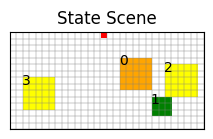

Moved 2 to: [2. 3.] | cost: 4.300 | done: False


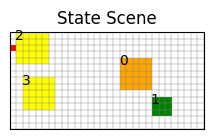

Moved 0 to: [12. 15.] | cost: 4.267 | done: False


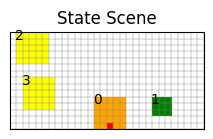

Moved 1 to: [ 7. 17.] | cost: 1.667 | done: False


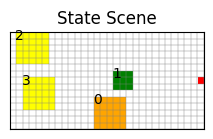

Moved 1 to: [13. 21.] | cost: 1.267 | done: False


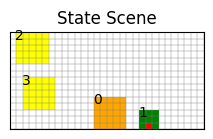

Moved 1 to: [ 3. 16.] | cost: 2.600 | done: False


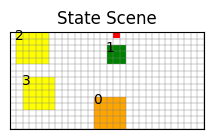

Moved 1 to: [13. 11.] | cost: 3.000 | done: False


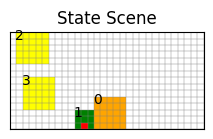

Moved 1 to: [ 3. 11.] | cost: 2.667 | done: False


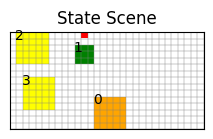

Moved 1 to: [ 8. 23.] | cost: 2.000 | done: False


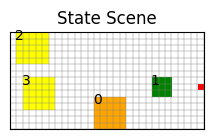

Moved 2 to: [ 7. 19.] | cost: 5.467 | done: False


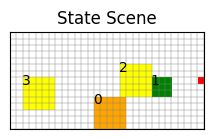

Moved 0 to: [4. 2.] | cost: 3.400 | done: False


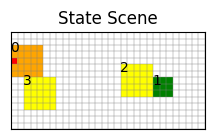

In [18]:
class BaseGraphEnv():
	def __init__(self, num_nodes, grid_size, max_steps=200):
		self.max_steps = max_steps
		self.num_nodes = num_nodes
		self.grid_size = grid_size

	def is_terminal_state(self):
		return torch.equal(self.state_graph.x, self.target_graph.x)

	def same_coor_in_target_graph(self, node, coor):
		return torch.equal(self.target_graph.x[node, Indices.COORD], coor)

	def check_loop_by_replacing_edge(self, start_node, prev_target, target_node):
		edge_index = self.state_graph.edge_index.clone()
		if prev_target is not None:
			mask = ~((edge_index[0] == start_node) & (edge_index[1] == prev_target))
			edge_index = edge_index[:, mask]
		new_edge = torch.tensor([[start_node], [target_node]], dtype=torch.long)
		edge_index = torch.cat([edge_index, new_edge], dim=1)
		return has_cycles(Data(x=self.state_graph.x, edge_index=edge_index))

	def remove_edge(self, node1, node2):
		mask = ~((self.state_graph.edge_index[0] == node1) & (self.state_graph.edge_index[1] == node2))
		self.state_graph.edge_index = self.state_graph.edge_index[:, mask]
		self.state_graph.x[node1][Indices.RELATION.start+node2] = 0

	def add_edge(self, node1, node2):
		new_edge = torch.tensor([[node1], [node2]], dtype=torch.long)
		self.state_graph.edge_index = torch.cat([self.state_graph.edge_index, new_edge], dim=1)
		self.state_graph.x[node1][Indices.RELATION.start+node2] = 1
		destination = self.state_graph.x[node2, Indices.COORD].clone()
		return self.move_node_with_parents(node1, destination)

	def decode_action(self, action: int):
		n = self.num_nodes
		m = self.grid_size[0] * self.grid_size[1]
		num_edge_actions = n * (n - 1)
		coordinates = 0

		if action < num_edge_actions:
			action_type = 'on'
			start_node = action // (n - 1)
			target_node = action % (n - 1)
			if target_node >= start_node:
				target_node += 1
		else:
			action_type = 'move'
			adjusted_action = action - num_edge_actions
			start_node = adjusted_action // m
			coordinates = adjusted_action % m
			target_node = start_node

		return action_type, start_node, target_node, coordinates

	def encode_action(self, action_type: str, start_node: int, target_node: int, coordinates: Union[int, list, np.ndarray, torch.Tensor])-> int:

		# Convert coordinate pair to flattened index if needed
		if isinstance(coordinates, torch.Tensor):
			coordinates = int(flatten_pos(coordinates, self.grid_size).item())
		elif isinstance(coordinates, list) or isinstance(coordinates, np.ndarray):
			coordinates = int(flatten_pos(coordinates, self.grid_size))

		n = self.num_nodes
		m = self.grid_size[0] * self.grid_size[1]
		num_edge_actions = n * (n - 1)

		if action_type == 'on':
			if target_node >= start_node:
				target_node -= 1
			action = start_node * (n - 1) + target_node
		elif action_type == 'move':
			action = num_edge_actions + start_node * m + coordinates
		else:
			raise ValueError('Invalid action type')

		return action

	def move_node_with_parents(self, node, coordinates):
		reward = 0
		n = self.num_nodes
		# Find all parents of the node and their parents recursively and move them
		visited = [False] * n
		visited[node] = True
		stack = [node]
		while len(stack) > 0:
			node = stack.pop()
			prev_coordinates = self.state_graph.x[node, Indices.COORD].clone()
			self.state_graph.x[node, Indices.COORD] = coordinates.clone()
			if not torch.equal(prev_coordinates, coordinates):
				if self.same_coor_in_target_graph(node, prev_coordinates):
					reward -= 1
				elif self.same_coor_in_target_graph(node, coordinates):
					reward += 1
			parents = get_parents(node, self.state_graph.edge_index)
			for i in parents:
				if not visited[i]:
					stack.append(i)
					visited[i] = True
		return reward

class ContinuousEnv(BaseGraphEnv):
	def __init__(self, mode, verbose=1, **kwargs):
		super().__init__(**kwargs)
		self.mode = mode
		if self.mode == 'mobile':
			self.manipulator_initial_pos = torch.tensor([0, (self.grid_size[1]-1)/2], dtype=torch.float32)
		elif self.mode == 'manipulator':
			self.manipulator_initial_pos = torch.tensor([(self.grid_size[0]-1)/2, (self.grid_size[1]-1)/2], dtype=torch.float32)
		else:
			raise ValueError('Invalid mode')
		self.manipulator = self.manipulator_initial_pos.clone()
		self.normalization_factor = 1 / min(self.grid_size)
		self.manipulator = self.manipulator_initial_pos.clone()
		self.pp_cost = 0.2
		self.punish_cost = 100
		self.num_labels = 4
		self.verbose = verbose

	def create_graph(self, labels=None, stack=True, ratio=0.5):
		if stack:
			return create_graph_label_continuous(self.num_nodes, self.grid_size, self.num_labels, OBJECT_SIZES, labels, p=0.9, ratio=ratio)
		else:
			return create_graph_label_continuous(self.num_nodes, self.grid_size, self.num_labels, OBJECT_SIZES, labels, p=0.0, ratio=ratio)

	def make_table(self, state_graph=None):
		if state_graph is None:
			state_graph = self.state_graph

		self.table = np.zeros(self.grid_size, dtype=int)
		for i in range(self.num_nodes):
			if state_graph.x[i, Indices.RELATION].sum() > 0:
				continue
			coor = state_graph.x[i, Indices.COORD].numpy()
			size = self.obj_size(i)
			self.table[in_table_index(coor, size)] = i+1

	def make_target_table(self):
		self.target_table = np.zeros(self.grid_size, dtype=int)
		for i in range(self.num_nodes):
			if self.target_graph.x[i, Indices.RELATION].sum() > 0:
				continue
			coor = self.target_graph.x[i, Indices.COORD].numpy()
			size = self.obj_size(i)
			self.target_table[in_table_index(coor, size)] = i+1

	def _get_obs(self):
		return {'graph': copy_graph(self.state_graph), 'manipulator': self.manipulator.clone()}
	
	def set_state(self, state):
		self.state_graph = copy_graph(state['graph'])
		self.manipulator = state['manipulator'].clone()
		self.make_table()

	def get_state(self):
		return self._get_obs()

	def reset(self, state_graph=None, target_graph=None, stack=True, ratio=0.5):
		self.steps = 0
		self.state_graph = self.create_graph(stack=stack, ratio=ratio) if state_graph is None else copy_graph(state_graph)
		self.initial_graph = copy_graph(self.state_graph)
		labels = list(self.state_graph.x[:, Indices.LABEL].reshape(-1).numpy())
		labels = list(map(int, labels))
		if target_graph is None:
			self.target_graph = self.create_graph(labels, stack=stack, ratio=1-ratio)
			while torch.equal(self.state_graph.x, self.target_graph.x):
				self.target_graph = self.create_graph(labels, stack=stack, ratio=1-ratio)
		else:
			self.target_graph = copy_graph(target_graph)
			target_labels = list(self.target_graph.x[:, Indices.LABEL].reshape(-1).numpy())
			target_labels = list(map(int, target_labels))
			# check whether the target graph has the same labels as the state graph
			if labels != target_labels:
				raise ValueError('Target graph has different labels than the state graph')

		if stack is False:
			for i in range(self.num_nodes):
				if torch.sum(self.state_graph.x[i, Indices.RELATION]) > 0:
					raise ValueError('Initial graph has edges in Non-stack mode')
				if torch.sum(self.target_graph.x[i, Indices.RELATION]) > 0:
					raise ValueError('Target graph has edges in Non-stack mode')
			
		self.manipulator = self.manipulator_initial_pos.clone()
		
		self.make_table()
		self.make_target_table()
		return self._get_obs(), {}

	def render(self, with_target=True, fig_size=2.5, return_fig=False):
		if self.verbose > 0:
			print(f'Manipulator: {self.manipulator.numpy()}')
		if with_target:
			fig, ax = plt.subplots(1, 2, figsize=(fig_size * 2, fig_size))
			plot_graph(self.state_graph, self.grid_size, ax=ax[0], fig_size=fig_size, title='State Scene', constraints=[])
			plot_graph(self.target_graph, self.grid_size, ax=ax[1], fig_size=fig_size, title='Target Scene')
		else:
			fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size))
			plot_graph(self.state_graph, self.grid_size, ax=ax, fig_size=fig_size, title='State Scene', constraints=[self.manipulator])

		if return_fig:
			plt.close()
			return fig
		else:
			plt.show()

	def get_valid_stacks(self):
		valid_stacks = []
		for k in range(self.num_nodes):
			empty_objects = get_empty_objects(self, ref_node=k, n=np.inf)
			for i in empty_objects:
				valid_stacks.append(self.encode_action('on', k, i, 0))
		return valid_stacks
	
	def get_valid_moves(self):
		valid_moves = []
		for k in range(self.num_nodes):
			if torch.equal(self.state_graph.x[k, Indices.COORD], self.target_graph.x[k, Indices.COORD]):
				continue

			positions = get_empty_positions(self, ref_node=k, n=np.inf)
			for position in positions:
				valid_moves.append(self.encode_action('move', k, k, position))
		return valid_moves

	def get_valid_actions(self):
		valid_actions = self.get_valid_stacks() + self.get_valid_moves()
		return valid_actions

	def move_node_with_parents(self, node, coordinates):
		n = self.state_graph.num_nodes
		# Find all parents of the node and their parents recursively and move them
		visited = [False] * n
		visited[node] = True
		stack = [node]
		while len(stack) > 0:
			node = stack.pop()
			self.state_graph.x[node, Indices.COORD] = coordinates.clone()
			i = find_start_node(self.state_graph, node)
			if i is not None and not visited[i]:
				stack.append(i)
				visited[i] = True
	
	def move_func(self, start_node, coordinates):
		if self.is_coor_occupied(coordinates, start_node):
			print('occupied')
			cost = self.punish_cost
		else:
			prev_target = find_target_node(self.state_graph, start_node)
			if prev_target is not None:
				self.remove_edge(start_node, prev_target)
			prev_coord = self.state_graph.x[start_node, Indices.COORD].clone()
			self.move_node_with_parents(start_node, coordinates)
			cost = self.cal_movement(prev_coord, coordinates)
		return cost

	def stack_func(self, start_node, target_node):
		if not is_stable(self.state_graph.x, start_node, target_node):
			cost = self.punish_cost
		elif not is_empty_object(self.state_graph, target_node):
			cost = self.punish_cost
		else:
			prev_target = find_target_node(self.state_graph, start_node)
			if prev_target == target_node:
				cost = self.punish_cost
			# elif self.check_loop_by_replacing_edge(start_node, prev_target, target_node):
			# 	cost = self.punish_cost
			elif prev_target is None:
				prev_coord = self.state_graph.x[start_node, Indices.COORD].clone()
				self.add_edge(start_node, target_node)
				cost = self.cal_movement(prev_coord, self.state_graph.x[target_node, Indices.COORD])
			else:
				prev_coord = self.state_graph.x[start_node, Indices.COORD].clone()
				self.remove_edge(start_node, prev_target)
				self.add_edge(start_node, target_node)
				cost = self.cal_movement(prev_coord, self.state_graph.x[target_node, Indices.COORD])
		return cost

	def is_coor_occupied(self, coor, node, table=None):
		if table is None:
			table = self.table
		
		size = self.obj_size(node)

		if torch.equal(coor, self.state_graph.x[node, Indices.COORD]):
			return True
		if coor[0] - size[0]//2 < 0 or coor[0] + size[0]//2 >= self.grid_size[0]:
			return True
		if coor[1] - size[1]//2 < 0 or coor[1] + size[1]//2 >= self.grid_size[1]:
			return True
		
		if np.any((table[in_table_index(coor, size)] != 0) & (table[in_table_index(coor, size)] != node+1)):
			return True
		return False

	def occupied_score(self, coor, node, table=None):
		if table is None:
			table = self.target_table
		
		size = self.obj_size(node)
		occupied = np.sum((table[in_table_index(coor, size)] != 0) & (table[in_table_index(coor, size)] != node+1))
		return occupied / (size[0] * size[1])

	def get_obj_label(self, node):
		return self.state_graph.x[node, Indices.LABEL].item()

	def obj_size(self, node):
		return get_obj_size(self.get_obj_label(node))
	
	def manipulator_decode(self, coord):
		x, y = coord
		grid_height, grid_width = self.grid_size
		# Avoid division by zero if dimensions are 1
		norm_x = x / (grid_height - 1) if grid_height > 1 else 0
		norm_y = y / (grid_width - 1) if grid_width > 1 else 0

		# Use normalized comparisons to decide which edge the coordinate is closest to.
		if norm_x < norm_y and norm_x < (1 - norm_y):
			# Closer to the top edge
			return 0, y, grid_width - 1 - y
		elif norm_x <= norm_y and norm_x >= (1 - norm_y):
			# Closer to the right edge
			return 1, x, grid_height - 1 - x
		elif norm_x >= norm_y and norm_x >= (1 - norm_y):
			# Closer to the bottom edge
			return 2, grid_width - 1 - y, y
		else:
			# Closer to the left edge
			return 3, grid_height - 1 - x, x

	def cal_manipulator_movement(self, pre_coord, new_coord):
		pre_s, pre_cc, pre_cw = self.manipulator_decode(pre_coord)
		new_s, new_cc, new_cw = self.manipulator_decode(new_coord)
		if pre_s == new_s:
			if pre_s == 0 or pre_s == 2:
				return torch.norm(pre_coord[1] - new_coord[1])
			else:
				return torch.norm(pre_coord[0] - new_coord[0])
		elif (new_s==1 and pre_s==3) or (new_s==3 and pre_s==1):
			return min(pre_cw + new_cc, pre_cc + new_cw) + self.grid_size[1]
		elif (new_s==2 and pre_s==0) or (new_s==0 and pre_s==2):
			return min(pre_cw + new_cc, pre_cc + new_cw) + self.grid_size[0]
		elif new_s == pre_s+1 or (new_s == 0 and pre_s == 3):
			return pre_cw + new_cc + 1
		else:
			return pre_cc + new_cw + 1

	def cal_movement(self, pre_coord, new_coord):
		total_movement = 0
		if self.mode == 'mobile':
			total_movement += self.cal_manipulator_movement(self.manipulator, pre_coord)
			total_movement += self.cal_manipulator_movement(pre_coord, new_coord)
			new_s = self.manipulator_decode(new_coord)[0]
			if new_s == 0:
				self.manipulator = torch.tensor([0, new_coord[1]], dtype=torch.float32)
			elif new_s == 1:
				self.manipulator = torch.tensor([new_coord[0], self.grid_size[1]-1], dtype=torch.float32)
			elif new_s == 2:
				self.manipulator = torch.tensor([self.grid_size[0]-1, new_coord[1]], dtype=torch.float32)
			else:
				self.manipulator = torch.tensor([new_coord[0], 0], dtype=torch.float32)
		elif self.mode == 'manipulator':
			total_movement += torch.norm(pre_coord - self.manipulator)
			total_movement += torch.norm(new_coord - pre_coord)
			self.manipulator = new_coord.clone()

		return total_movement * self.normalization_factor

	def random_action(self):
		return random.choice(self.get_valid_actions())

	def step_move(self, node, coordinates, log=True):
		action = self.encode_action('move', node, node, flatten_pos(coordinates, self.grid_size))
		return self.step(action, log)

	def step_on(self, start_node, target_node, log=True):
		action = self.encode_action('on', start_node, target_node, 0)
		return self.step(action, log)

	def step(self, action, log=False):
		action_type, start_node, target_node, coordinates = self.decode_action(action)
		return self._step(action_type, start_node, target_node, coordinates, log=log)

	def _step(self, action_type, start_node, target_node, coordinates, log=False):
		coordinates = unflatten_pos(coordinates, self.grid_size)
		cost, truncated, terminated = 0.0, False, False

		if action_type == 'move':
			cost += self.move_func(start_node, coordinates)
		elif action_type == 'on':
			cost += self.stack_func(start_node, target_node)
			
		cost += self.pp_cost
		
		if self.is_terminal_state():
			if self.mode == 'mobile':
				cost += self.cal_manipulator_movement(self.manipulator, self.manipulator_initial_pos) * self.normalization_factor
			elif self.mode == 'manipulator':
				cost += torch.norm(self.manipulator - self.manipulator_initial_pos) * self.normalization_factor
			else:
				raise ValueError('Invalid mode')
			# self.manipulator = self.manipulator_initial_pos.clone()
			terminated = True
	
		if log:
			if action_type == 'move':
				print(f'Moved {start_node} to: {coordinates.numpy()} | cost: {cost:.3f} | done: {terminated or truncated}')
			else:
				print(f'{start_node} -> {target_node} | cost: {cost:.3f} | done: {terminated or truncated}')

		self.make_table()
		return cost, self.get_state()

env = ContinuousEnv(mode='mobile', num_nodes=4, grid_size=(15, 30), verbose=0)
env.reset(stack=False, ratio=0.5)
initial_graph, target_graph = copy_graph(env.initial_graph), copy_graph(env.target_graph)
env.reset(initial_graph, target_graph)
env.render(with_target=False)
for i in range(10):
	env.step(env.random_action(), log=True)
	env.render(with_target=False)


# Algs

In [ ]:
class SearchAlg:
    def __init__(self, env, node_class):
        """
        Base class for search algorithms.
        :param env: The environment in which the search is performed.
        :param node_class: The class used for representing nodes in the search.
        """
        self.env = env
        self.node_class = node_class  # Generalized node class

class LabbeNode:
	node_counter = 0  # Static variable to assign unique IDs to each node

	def __init__(self, state, remaining_nodes, parent=None, action=None, c=1):
		self.state = state
		self.parent = parent
		self.action = action
		self.children = {}
		self.n = 0
		self.w = 0.0
		self.c = c
		self.terminal_flag = False
		self.unexpanded_actions = remaining_nodes
		
		# Assign a unique ID to each node
		self.id = LabbeNode.node_counter
		LabbeNode.node_counter += 1

	def get_state(self):
		return copy_state(self.state)

	def is_fully_expanded(self):
		return len(self.unexpanded_actions) == 0

	def ucb(self):
		if self.n == 0:
			return float('inf')  # Prioritize unvisited nodes

		expected_value = self.w / self.n
		exploration_term = self.c * np.sqrt(2 * np.log(self.parent.n) / self.n)

		return expected_value + exploration_term

	def best_child(self):
		# Accesses child nodes for best selection
		return max(self.children.values(), key=lambda child: child.ucb())

class Labbe(SearchAlg):
	def __init__(self, env):
		super().__init__(env, LabbeNode)

	def backup_search(self, node, reward, terminal_flag):
		while node is not None:
			node.n += 1
			node.w += reward
			node.terminal_flag = terminal_flag or node.terminal_flag
			node = node.parent

	def expand(self, node):
		if node.is_fully_expanded():
			return None  # Prevents further expansion if no actions remain

		self.env.set_state(node.get_state())
		# random.shuffle(node.unexpanded_actions)
		action = self.get_motion(node.unexpanded_actions.pop())
		if action is None:
			return None
		_, child_state = self.env.step_cost(action)

		# Continue expanding if the state hasn't changed
		if torch.equal(child_state['graph'].x, node.state['graph'].x):
			return self.expand(node)

		remaining_nodes = self.get_remaining_nodes(self.env.get_state())
		child_node = self.node_class(child_state, remaining_nodes, node, action, node.c)
		node.children[action] = child_node
		return child_node

	def print_tree(self, node, depth=0, ter=False):
		# Print the current node with indentation to show its depth in the tree
		indent = "    " * depth  # Four spaces per level of depth
		if node.id == 0:
			print(f"Root | Visits: {node.n} | Value: {node.w:.2f} | Terminal: {node.terminal_flag}")
		else:
			print(f"{indent}ID: {node.id} | Action: {node.action} | "
					f"Visits: {node.n} | Value: {node.w:.2f} | Terminal: {node.terminal_flag}")

		# Sort children by value estimate
		if ter:
			accepted_children = [child for child in node.children.values() if child.terminal_flag]
			children = sorted(accepted_children, key=lambda child: child.w / child.n if child.n > 0 else float('inf'))
		else:
			children = sorted(node.children.values(), key=lambda child: child.w / child.n if child.n > 0 else float('inf'))

		# Recurse on children
		for child in children:
			self.print_tree(child, depth + 1, ter)

	def evaluate_state(self, state):
		state_graph = state['graph']
		reward = 0
		
		for k in range(state_graph.num_nodes):
			i = find_target_node(self.env.target_graph, k)
			if i is not None:
				if is_edge_in_graph(state_graph, k, i):
					reward += 1
			elif find_target_node(state_graph, k) is None:
				if torch.equal(state_graph.x[k, Indices.COORD], self.env.target_graph.x[k, Indices.COORD]):
					reward += 1

		return reward

	def find_best_path(self, ter=False):
		path = []
		current_node = self.root_node

		while current_node.children:
			if ter:
				accepted_children = [child for child in current_node.children.values() if child.terminal_flag]
				if len(accepted_children) == 0:
					break
				next_node = max(accepted_children, key=lambda child: child.w / child.n if child.n > 0 else float('inf'))
			else:
				next_node = max(current_node.children.values(), key=lambda child: child.w / child.n if child.n > 0 else float('inf'))
			path.append((next_node.action, next_node.w))
			current_node = next_node

		return [action for action, _ in path]

	def get_remaining_nodes(self, state):
		state_graph = state['graph']

		remaining_nodes = []
		for k in range(state_graph.num_nodes):
			if not torch.equal(state_graph.x[k, Indices.COORD], self.env.target_graph.x[k, Indices.COORD]):
				remaining_nodes.append(k)

		# shuffle remaining nodes
		random.shuffle(remaining_nodes)

		return remaining_nodes

	def get_motion(self, k):
		Tk = self.env.target_graph.x[k, Indices.COORD]
		CK = self.env.state_graph.x[k, Indices.COORD]
		if torch.equal(Tk, CK):
			return None
		elif not self.env.is_coor_occupied(Tk, k):
			# Tk is free
			position = Tk[0] * self.env.grid_size + Tk[1]
			return self.env.encode_action('move', k, k, int(position.item()))
		else:
			# find which node is occupying Tk
			size = self.env.get_obj_size(k)
			occupying_nodes = find_occupying_nodes(self.env.table, Tk, size)
			if len(occupying_nodes) == 0:
				return None
			j = random.choice(occupying_nodes)
			free_positions = get_empty_positions(self.env, ref_node=j, n=1)
			if len(free_positions) == 0:
				return None
			return self.env.encode_action('move', j, j, free_positions[0])

	def loop(self):
		node = self.root_node

		# Selection
		self.env.set_state(node.get_state())
		while node.is_fully_expanded() and not self.env.is_terminal_state():
			node = node.best_child()
			self.env.set_state(node.get_state())

		# Expansion
		if not self.env.is_terminal_state():
			node = self.expand(node)
			if node is None:
				return

		# Backpropagation
		terminal_flag = True if self.env.is_terminal_state() else False
		reward = self.evaluate_state(node.get_state())
		self.backup_search(node, reward, terminal_flag)

	def solve(self, verbose=1, c=1):
		for i in range(self.env.num_nodes):
			if torch.sum(self.env.state_graph.x[:, Indices.RELATION.start+i]) > 0:
				raise ValueError('Initial graph has edges')
		return self._solve(verbose, c)

	def _solve(self, verbose=1, c=1):
		self.root_node = self.node_class(self.env.get_state(), self.get_remaining_nodes(self.env.get_state()), c=c)
		
		steps = 0
		if verbose > 0:
			pbar = tqdm(total=None, unit='iterations')
		while self.root_node.terminal_flag is False:
			steps += 1
			self.loop()
			if verbose > 0:
				pbar.update(1)
		if verbose > 0:
			pbar.close()

		return self.find_best_path(ter=True), steps

class LabbeS(Labbe):
	def get_remaining_nodes(self, state):
		state_graph = state['graph']

		remaining_nodes = []
		for k in range(state_graph.num_nodes):
			i = find_target_node(self.env.target_graph, k)
			if i is not None:
				if not is_edge_in_graph(state_graph, k, i):
					remaining_nodes.append(k)
			elif find_target_node(state_graph, k) is not None:
				remaining_nodes.append(k)
			else:
				if not torch.equal(state_graph.x[k, Indices.COORD], self.env.target_graph.x[k, Indices.COORD]):
					remaining_nodes.append(k)

		# shuffle remaining nodes
		random.shuffle(remaining_nodes)

		return remaining_nodes

	def get_action_move_node_away(self, k):
		free_position = get_empty_positions(self.env, ref_node=k, n=1)
		free_object = get_empty_objects(self.env, ref_node=k, n=1)
		if len(free_object) > 0 and len(free_position) > 0:
			if random.random() < 0.5:
				# move the node to a random position
				return self.env.encode_action('move', k, k, free_position[0])
			else:
				# stack on a random node
				return self.env.encode_action('on', k, free_object[0], 0)
		elif len(free_object) == 0 and len(free_position) > 0:
			# move the node to a random position
			return self.env.encode_action('move', k, k, free_position[0])
		elif len(free_position) == 0 and len(free_object) > 0:
			# stack on a random node
			return self.env.encode_action('on', k, free_object[0], 0)
		return None
	
	def get_motion(self, k):
		i = find_target_node(self.env.target_graph, k)
		if i is not None:
			j = find_start_node(self.env.state_graph, i)
			if j is not None:
				return self.get_action_move_node_away(j)
			else:
				return self.env.encode_action('on', k, i, 0)
		else:
			j = find_target_node(self.env.state_graph, k)
			Tk = self.env.target_graph.x[k, Indices.COORD]
			CK = self.env.state_graph.x[k, Indices.COORD]
			if torch.equal(Tk, CK):
				if j is not None:
					j = find_base_node(self.env.state_graph, j)
					return self.get_action_move_node_away(j)
			else:
				if not self.env.is_coor_occupied(Tk, k):
					# Tk is free
					position = Tk[0] * self.env.grid_size + Tk[1]
					return self.env.encode_action('move', k, k, int(position.item()))
				else:
					# find which nodes are occupying Tk
					size = self.env.get_obj_size(k)
					occupying_nodes = find_occupying_nodes(self.env.table, Tk, size)
					if len(occupying_nodes) == 0:
						return None
					j = random.choice(occupying_nodes)
					return self.get_action_move_node_away(j)

	def solve(self, verbose=1, c=1):
		return self._solve(verbose, c)

class MultiLabbe(Labbe):
	"""run multiple Labbe instances in parallel and return the best solution"""
	def solve(self, num_agents, verbose=1, c=1):
		best_path, best_cost = None, float('inf')
		for _ in range(num_agents):
			path, steps = self._solve(verbose, c)
			if steps < best_steps:
				best_path, best_steps = path, steps
		return best_path, best_steps


In [ ]:
class SearchNode:
	def __init__(self, state, parent=None, action=None, cost_to_come=0, heuristic=0, depth=0):
		self.state = state
		self.parent = parent
		self.action = action
		self.c_cost = cost_to_come	  	# cost-to-come
		self.h_cost = heuristic			# cost-to-go
		self.total_cost = self.c_cost + self.h_cost
		self.depth = depth

	def __lt__(self, other):
		return self.total_cost < other.total_cost  # Lower cost first

	def get_state(self):
		return copy_state(self.state)

def find_required_max_depth(env, state, max_depth=100, stack=False):
	steps = 0
	for _ in range(5):
		env.set_state(copy_state(state))
		if stack:
			feasible_path, labbe_steps = LabbeS(env).solve(verbose=0)
		else:
			feasible_path, labbe_steps = Labbe(env).solve(verbose=0)
		steps += labbe_steps
		max_depth = min(max_depth, len(feasible_path))
	return max_depth, steps

class Dijkstra(SearchAlg):
	def __init__(self, env):
		super().__init__(env, SearchNode)

	def get_valid_actions(self, state):
		return self.env.get_valid_actions()

	def solve(self, max_depth=100):
		steps = 0
		start_node = self.node_class(self.env.get_state(), cost_to_come=0)

		queue = []
		heapq.heappush(queue, start_node)
		visited = {}

		while queue:
			current_node = heapq.heappop(queue)

			# Check if the current node's state matches the target state
			self.env.set_state(current_node.get_state())
			if self.env.is_terminal_state():
				return reconstruct_path(current_node), steps

			if current_node.depth >= max_depth:
				continue

			last_changed_node = self.env.decode_action(current_node.action)[1] if current_node.action is not None else None
			for action in self.get_valid_actions(current_node.get_state()):
				steps += 1
				self.env.set_state(current_node.get_state())
				action_type, start_node, target_node, coordinates = self.env.decode_action(action)

				if last_changed_node == start_node:
					# if the last changed node is the same as the current node, continue
					continue

				cost, child_state = self.env._step_cost(action_type, start_node, target_node, coordinates)

				if torch.equal(child_state['graph'].x, current_node.get_state()['graph'].x):
					# if state hasn't changed, continue
					continue
				
				child_hash = state_to_hashable(child_state)

				# Calculate the accumulated cost for the current path
				new_total_cost = current_node.total_cost + cost

				# Retain the node with better cost
				if child_hash not in visited or visited[child_hash] > new_total_cost:
					visited[child_hash] = new_total_cost
					child_node = self.node_class(child_state, current_node, action, cost_to_come=new_total_cost, depth=current_node.depth+1)

					heapq.heappush(queue, child_node)

		return None, steps  # No path found

class A_star(SearchAlg):
	def __init__(self, env):
		super().__init__(env, SearchNode)
		self.num_buffers = 2

	def evaluate_state(self, state):
		state_graph = state['graph']
		heuristic = 0

		for k in range(state_graph.num_nodes):
			TK = self.env.target_graph.x[k, Indices.COORD]
			CK = state_graph.x[k, Indices.COORD]
			min_dis = torch.norm(CK - TK)

			i = find_target_node(self.env.target_graph, k)
			if i is not None:
				if not is_edge_in_graph(state_graph, k, i):
					CI = state_graph.x[i, Indices.COORD]
					new_dis = torch.norm(CK - CI)
					if new_dis < min_dis:
						min_dis = new_dis
						if find_start_node(state_graph, i) is not None:
							heuristic += self.env.pp_cost
					heuristic += self.env.pp_cost
					heuristic += self.env.normalization_factor * min_dis
			elif find_target_node(state_graph, k) is not None:
				if min_dis == 0:
					heuristic += self.env.pp_cost
			else:
				if min_dis != 0:
					stack = False
					for j in range(state_graph.num_nodes):
						if k != j and is_stable(state_graph.x, k, j):
							CJ = state_graph.x[j, Indices.COORD]
							TJ = self.env.target_graph.x[j, Indices.COORD]
							new_dis = torch.norm(CK - CJ) + torch.norm(TK - TJ)
							if new_dis < min_dis:
								min_dis = new_dis
								stack = True
					if stack:
						heuristic += self.env.pp_cost
					heuristic += self.env.pp_cost
					heuristic += self.env.normalization_factor * min_dis
		
		# return self.env.normalize_cost(heuristic)
		return heuristic

	def evaluate_state(self, state):
		state_graph = state['graph']
		heuristic = 0

		for k in range(state_graph.num_nodes):
			TK = self.env.target_graph.x[k, Indices.COORD]
			CK = state_graph.x[k, Indices.COORD]
			min_dis = torch.norm(CK - TK)

			i = find_target_node(self.env.target_graph, k)
			if i is not None:
				if not is_edge_in_graph(state_graph, k, i):
					CI = state_graph.x[i, Indices.COORD]
					new_dis = torch.norm(CK - CI)
					if new_dis < min_dis:
						min_dis = new_dis
						if find_start_node(state_graph, i) is not None:
							heuristic += self.env.pp_cost
					heuristic += self.env.pp_cost
					heuristic += self.env.normalization_factor * min_dis
			elif find_target_node(state_graph, k) is not None:
				if min_dis == 0:
					heuristic += self.env.pp_cost
			else:
				if min_dis != 0:
					stack = False
					for j in range(state_graph.num_nodes):
						if k != j and is_stable(state_graph.x, k, j):
							CJ = state_graph.x[j, Indices.COORD]
							TJ = self.env.target_graph.x[j, Indices.COORD]
							new_dis = torch.norm(CK - CJ) + torch.norm(TK - TJ)
							if new_dis < min_dis:
								min_dis = new_dis
								stack = True
					if stack:
						heuristic += self.env.pp_cost
					heuristic += self.env.pp_cost
					heuristic += self.env.normalization_factor * min_dis
		
		# return self.env.normalize_cost(heuristic)
		return heuristic

	def get_remaining_nodes(self, state):
		state_graph = state['graph']

		remaining_nodes = []
		for k in range(state_graph.num_nodes):
			i = find_target_node(self.env.target_graph, k)
			if i is not None:
				if not is_edge_in_graph(state_graph, k, i):
					remaining_nodes.append(k)
			elif find_target_node(state_graph, k) is not None:
				remaining_nodes.append(k)
			else:
				if not torch.equal(state_graph.x[k, Indices.COORD], self.env.target_graph.x[k, Indices.COORD]):
					remaining_nodes.append(k)

		# shuffle remaining nodes
		random.shuffle(remaining_nodes)

		return remaining_nodes

	def get_empty_positions_with_target(self, ref_node, n=1):
		positions = []
		target_pos = self.env.target_graph.x[ref_node, Indices.COORD]
		p = int(target_pos[0] * self.env.grid_size + target_pos[1])
		if not self.env.is_coor_occupied(target_pos, ref_node):
			positions.append(p)
		else:
			if n == 0:
				return positions
			all_positions = list(range(self.env.grid_size * self.env.grid_size))
			random.shuffle(all_positions)
			for position in all_positions:
				p = unflatten_pos(position, self.env.grid_size)
				if not torch.equal(p, target_pos) and not self.env.is_coor_occupied(p, ref_node):
					positions.append(position)
					if len(positions) >= n:
						break
		return positions

	def get_valid_actions(self, state):
		self.env.set_state(state)

		stack_nums = max(int(0.6 * self.num_buffers), 1)

		nodes = list(range(self.env.num_nodes))
		random.shuffle(nodes)

		valid_actions = []
		for k in self.get_remaining_nodes(state):
			valid_stacks = []
			for j in nodes:
				if k != j and not is_edge_in_graph(self.env.state_graph, k, j):
					if is_stable(self.env.state_graph.x, k, j):
						if is_empty_object(self.env.state_graph, j):
							valid_stacks.append(self.env.encode_action('on', k, j, 0))
							if len(valid_stacks) >= stack_nums:
								break

			valid_moves = []
			for position in self.get_empty_positions_with_target(ref_node=k, n=self.num_buffers-len(valid_stacks)):
				valid_moves.append(self.env.encode_action('move', k, k, position))
				
			valid_actions += valid_stacks + valid_moves

		return valid_actions

	def solve(self, max_depth=100, num_buffers=2):
		self.num_buffers = num_buffers
		return self._solve(max_depth)

	def _solve(self, max_depth=100):
		steps = 0
		h_cost = self.evaluate_state(self.env.get_state())
		start_node = self.node_class(self.env.get_state(), cost_to_come=0, heuristic=h_cost)

		queue = []
		heapq.heappush(queue, start_node)
		visited = {}

		while queue:
			current_node = heapq.heappop(queue)

			# Check if the current node's state matches the target state
			self.env.set_state(current_node.get_state())
			if self.env.is_terminal_state():
				return reconstruct_path(current_node), steps

			if current_node.depth >= max_depth:
				continue

			last_changed_node = self.env.decode_action(current_node.action)[1] if current_node.action is not None else None
			for action in self.get_valid_actions(current_node.get_state()):
				steps += 1
				action_type, start_node, target_node, coordinates = self.env.decode_action(action)

				if start_node == last_changed_node:
					# If the last changed node is the same as the current node, continue
					continue

				self.env.set_state(current_node.get_state())
				cost, child_state = self.env._step_cost(action_type, start_node, target_node, coordinates)

				if torch.equal(child_state['graph'].x, current_node.get_state()['graph'].x):
					# if state hasn't changed, continue
					continue

				child_hash = state_to_hashable(child_state)

				# Calculate the accumulated cost for the current path
				new_c_cost = current_node.c_cost + cost
				h_cost = self.evaluate_state(child_state)
				new_total_cost = new_c_cost + h_cost

				# Retain the node with better cost
				if child_hash not in visited or visited[child_hash] > new_total_cost:
					visited[child_hash] = new_total_cost
					child_node = self.node_class(
						state=child_state, 
						parent=current_node, 
						action=action, 
						cost_to_come=new_c_cost, 
						heuristic=h_cost,
						depth=current_node.depth+1
					)

					heapq.heappush(queue, child_node)

		return None, steps  # No path found

class A_starGA(A_star):
	def _solve(self, max_depth=100):
		best_plan = None
		best_cost = float('inf')

		steps = 0
		h_cost = self.evaluate_state(self.env.get_state())
		start_node = self.node_class(self.env.get_state(), cost_to_come=0, heuristic=h_cost)

		queue = []
		heapq.heappush(queue, start_node)
		visited = {}

		while queue:
			current_node = heapq.heappop(queue)

			# Check if the current node's state matches the target state
			self.env.set_state(current_node.get_state())
			if self.env.is_terminal_state():
				return reconstruct_path(current_node), steps

			if current_node.depth >= max_depth:
				continue

			last_changed_node = self.env.decode_action(current_node.action)[1] if current_node.action is not None else None
			for action in self.get_valid_actions(current_node.get_state()):
				steps += 1
				action_type, start_node, target_node, coordinates = self.env.decode_action(action)

				if start_node == last_changed_node:
					# If the last changed node is the same as the current node, continue
					continue

				self.env.set_state(current_node.get_state())
				cost, child_state = self.env._step_cost(action_type, start_node, target_node, coordinates)

				if torch.equal(child_state['graph'].x, current_node.get_state()['graph'].x):
					# if state hasn't changed, continue
					continue

				child_hash = state_to_hashable(child_state)

				# Calculate the accumulated cost for the current path
				new_c_cost = current_node.c_cost + cost
				h_cost = self.evaluate_state(child_state)
				new_total_cost = new_c_cost + h_cost

				# Retain the node with better cost
				if child_hash not in visited or visited[child_hash] > new_total_cost:
					visited[child_hash] = new_total_cost
					child_node = self.node_class(
						state=child_state, 
						parent=current_node, 
						action=action, 
						cost_to_come=new_c_cost, 
						heuristic=h_cost,
						depth=current_node.depth+1
					)

					heapq.heappush(queue, child_node)

			# Goal Attempting
			self.env.set_state(current_node.get_state())
			feasible_path, labbe_steps = LabbeS(self.env).solve(verbose=0)
			steps += labbe_steps

			feasible_path_cost = current_node.c_cost
			self.env.set_state(current_node.get_state())
			for action in feasible_path:
				feasible_path_cost += self.env.step_cost(action)[0]

			# Remove all the nodes with their total cost is greater than the feasible path cost
			for node in queue:
				if node.total_cost > feasible_path_cost:
					queue.remove(node)

			if feasible_path_cost < best_cost:
				best_plan = reconstruct_path(current_node) + feasible_path
				best_cost = feasible_path_cost

		return best_plan, steps  # No path found

class Strap(A_star):
	def evaluate_state(self, state):
		state_graph = state['graph']
		heuristic = 0

		for k in self.get_remaining_nodes(state):
			CK = state_graph.x[k, Indices.COORD]
			TK = self.env.target_graph.x[k, Indices.COORD]
			heuristic += torch.norm(CK - TK) * self.env.normalization_factor
			heuristic += self.env.pp_cost
		
		# return self.env.normalize_cost(heuristic)
		return heuristic

	def get_remaining_nodes(self, state):
		state_graph = state['graph']

		remaining_nodes = []
		for k in range(state_graph.num_nodes):
			if not torch.equal(state_graph.x[k, Indices.COORD], self.env.target_graph.x[k, Indices.COORD]):
				remaining_nodes.append(k)

		# shuffle remaining nodes
		random.shuffle(remaining_nodes)
		
		return remaining_nodes

	def get_valid_actions(self, state):
		self.env.set_state(copy_state(state))

		valid_actions = []
		for k in self.get_remaining_nodes(state):
			Tk = self.env.target_graph.x[k, Indices.COORD]
			if not self.env.is_coor_occupied(Tk, k):
				# Tk is free
				valid_actions.append(self.env.encode_action('move', k, k, Tk))
			else:
				# Choose random buffer position
				for position in get_empty_positions(self.env, ref_node=k, n=self.num_buffers):
					valid_actions.append(self.env.encode_action('move', k, k, position))

		return valid_actions

	def solve(self, max_depth=100, num_buffers=2, verbose=1):
		self.verbose = verbose

		self.env.reset(self.env.initial_graph, self.env.target_graph)
		max_depth, labbe_steps = find_required_max_depth(self.env, self.env.get_state(), max_depth, stack=False)
		if self.verbose > 0:
			print('max depth:', max_depth)

		self.env.reset(self.env.initial_graph, self.env.target_graph)
		optimal_path, steps = super().solve(max_depth=max_depth, num_buffers=num_buffers)
		# steps += labbe_steps

		return optimal_path, steps

class StrapGA(Strap):
	def _solve(self, max_depth=100):
		best_plan = None
		best_cost = float('inf')

		steps = 0
		h_cost = self.evaluate_state(self.env.get_state())
		start_node = self.node_class(self.env.get_state(), cost_to_come=0, heuristic=h_cost)

		queue = []
		heapq.heappush(queue, start_node)
		visited = {}

		while queue:
			current_node = heapq.heappop(queue)

			# Check if the current node's state matches the target state
			self.env.set_state(current_node.get_state())
			if self.env.is_terminal_state():
				return reconstruct_path(current_node), steps

			if current_node.depth >= max_depth:
				continue

			last_changed_node = self.env.decode_action(current_node.action)[1] if current_node.action is not None else None
			for action in self.get_valid_actions(current_node.get_state()):
				steps += 1
				action_type, start_node, target_node, coordinates = self.env.decode_action(action)

				if start_node == last_changed_node:
					# If the last changed node is the same as the current node, continue
					continue

				self.env.set_state(current_node.get_state())
				cost, child_state = self.env._step_cost(action_type, start_node, target_node, coordinates)

				if torch.equal(child_state['graph'].x, current_node.get_state()['graph'].x):
					# if state hasn't changed, continue
					continue

				child_hash = state_to_hashable(child_state)

				# Calculate the accumulated cost for the current path
				new_c_cost = current_node.c_cost + cost
				h_cost = self.evaluate_state(child_state)
				new_total_cost = new_c_cost + h_cost

				# Retain the node with better cost
				if child_hash not in visited or visited[child_hash] > new_total_cost:
					visited[child_hash] = new_total_cost
					child_node = self.node_class(
						state=child_state, 
						parent=current_node, 
						action=action, 
						cost_to_come=new_c_cost, 
						heuristic=h_cost,
						depth=current_node.depth+1
					)

					heapq.heappush(queue, child_node)

			# Goal Attempting
			self.env.set_state(current_node.get_state())
			feasible_path, labbe_steps = Labbe(self.env).solve(verbose=0)
			steps += labbe_steps

			feasible_path_cost = current_node.c_cost
			self.env.set_state(current_node.get_state())
			for action in feasible_path:
				feasible_path_cost += self.env.step_cost(action)[0]

			# Remove all the nodes with their total cost is greater than the feasible path cost
			for node in queue:
				if node.total_cost > feasible_path_cost:
					queue.remove(node)

			if feasible_path_cost < best_cost:
				best_plan = reconstruct_path(current_node) + feasible_path
				best_cost = feasible_path_cost

		return best_plan, steps  # No path found


In [ ]:
def score(env, coor, obj):
	dis_obj = torch.norm(env.target_graph.x[obj, Indices.COORD] - coor).item()
	return env.occupied_score(coor, obj) + dis_obj * env.normalization_factor

class MctsNode:
	node_counter = 0  # Static variable to assign unique IDs to each node

	def __init__(self, state, valid_actions, parent=None, action=None, cost_to_come=0.0, c=1, depth=0):
		self.state = state
		self.parent = parent
		self.action = action
		self.children = {}
		self.visit_count = 0
		self.value = float('inf')
		self.value_upper = -float('inf')
		self.c_cost = cost_to_come
		self.c = c
		self.unexpanded_actions = valid_actions
		self.depth = depth
		
		# Assign a unique ID to each node
		self.id = MctsNode.node_counter
		MctsNode.node_counter += 1

	def get_state(self):
		return copy_state(self.state)

	def is_fully_expanded(self):
		return len(self.unexpanded_actions) == 0

	def uct(self):
		# if self.visit_count == 0:
		# 	return -float('inf')  # Prioritize unvisited nodes
		# visit_count = self.visit_count
		visit_count = self.visit_count + 1

		total_cost_estimate = self.value #(self.parent.value - self.value) / (self.parent.value_upper - self.value_upper)
		exploration_term = self.c * np.sqrt(2 * np.log(self.parent.visit_count) / visit_count)

		return total_cost_estimate - exploration_term  # Minimization form

class Sorp(SearchAlg):
	def __init__(self, env, node_class=None):
		if node_class is None:
			node_class = MctsNode
		super().__init__(env, node_class)
		self.num_buffers = 2

	def get_remaining_nodes(self, state):
		state_graph = state['graph']

		remaining_nodes = []
		for k in range(state_graph.num_nodes):
			i = find_target_node(self.env.target_graph, k)
			if i is not None:
				if not is_edge_in_graph(state_graph, k, i):
					remaining_nodes.append(k)
			elif find_target_node(state_graph, k) is not None:
				remaining_nodes.append(k)
			else:
				if not torch.equal(state_graph.x[k, Indices.COORD], self.env.target_graph.x[k, Indices.COORD]):
					remaining_nodes.append(k)

		# shuffle remaining nodes
		random.shuffle(remaining_nodes)

		return remaining_nodes

	def get_empty_positions_with_target(self, ref_node, n=1):
		positions = []
		target_p = self.env.target_graph.x[ref_node, Indices.COORD]
		if not self.env.is_coor_occupied(target_p, ref_node):
			positions.append(flatten_pos(target_p, self.env.grid_size))
		else:
			if n == 0:
				return positions
			all_positions = get_all_positions_in_env(self.env.grid_size, self.env.get_obj_size(ref_node))
			# all_positions = sorted(all_positions, key=lambda x: score(self.env, torch.tensor(x), ref_node))
			random.shuffle(all_positions)
			
			for position in all_positions:
				position = torch.tensor(position)
				if not torch.equal(position, target_p) and not self.env.is_coor_occupied(position, ref_node):
					positions.append(flatten_pos(position, self.env.grid_size))
					if len(positions) >= n:
						break
		return positions

	def get_valid_actions(self, state):
		self.env.set_state(state)

		stack_nums = max(int(0.6 * self.num_buffers), 1)

		nodes = list(range(self.env.num_nodes))
		random.shuffle(nodes)

		valid_actions = []
		for k in self.get_remaining_nodes(state):
			valid_stacks = []
			for j in nodes:
				if k != j and not is_edge_in_graph(self.env.state_graph, k, j):
					if is_stable(self.env.state_graph.x, k, j):
						if is_empty_object(self.env.state_graph, j):
							valid_stacks.append(self.env.encode_action('on', k, j, 0))
							if len(valid_stacks) >= stack_nums:
								break

			valid_moves = []
			for position in self.get_empty_positions_with_target(ref_node=k, n=self.num_buffers-len(valid_stacks)):
				valid_moves.append(self.env.encode_action('move', k, k, position))

			valid_actions += valid_stacks + valid_moves

		return valid_actions

	def select(self, node):
		# Accesses child nodes for best selection
		return min(node.children.values(), key=lambda child: child.uct())

	def expand(self, node):
		if node.is_fully_expanded():
			return None  # Prevents further expansion if no actions remain

		action = node.unexpanded_actions.pop()
		self.env.set_state(node.get_state())
		action_type, start_node, target_node, coordinates = self.env.decode_action(action)

		# Continue expanding if the last changed node is the same as the current node
		if node.action is not None:
			_, last_changed_node, _, _ = self.env.decode_action(node.action)
			if last_changed_node == start_node:
				return self.expand(node)

		cost, child_state = self.env._step_cost(action_type, start_node, target_node, coordinates)

		# Continue expanding if the state hasn't changed
		if torch.equal(child_state['graph'].x, node.state['graph'].x):
			return self.expand(node)

		new_c_cost = cost + node.c_cost
		child_node = self.node_class(child_state, self.get_valid_actions(self.env.get_state()), node, action, new_c_cost, node.c, node.depth+1)
		node.children[action] = child_node
		return child_node

	def rollout(self, state):
		self.env.set_state(state)
		costs = 0
		feasible_path, steps = LabbeS(self.env).solve(verbose=0)
		self.env.set_state(state)
		for action in feasible_path:
			costs += self.env.step_cost(action)[0]

		return costs, steps

	def rollout_live(self, node):
		costs = 0
		self.env.set_state(node.get_state())
		feasible_path, steps = LabbeS(self.env).solve(verbose=0)
		self.env.set_state(node.get_state())
		for action in feasible_path:
			cost, child_state = self.env.step_cost(action)
			costs += cost
			# remove action from the node's unexpanded actions
			if action in node.unexpanded_actions:
				node.unexpanded_actions.remove(action)
			# add the new child to the node
			new_c_cost = cost + node.c_cost
			child_node = self.node_class(child_state, self.get_valid_actions(self.env.get_state()), node, action, new_c_cost, node.c, node.depth+1)
			node.children[action] = child_node
			node = child_node

		return costs, steps, node

	def backup_search(self, node, c_min):
		while node is not None:
			node.visit_count += 1
			if node.value > c_min:
				node.value = c_min
			if node.value_upper < c_min:
				node.value_upper = c_min
			node = node.parent

	def print_tree(self, node, depth=0, max_depth=float('inf'), ter=False):
		if depth >= max_depth:
			return

		# Print the current node with indentation to show its depth in the tree
		indent = "    " * depth  # Four spaces per level of depth
		if node.id == 0:
			print(f"Root | Visits: {node.visit_count} | Value: {node.value:.2f}")
		else:
			print(f"{indent}Node ID: {node.id} | Action: {node.action} | cost: {node.c_cost:.2f} | "
					f"Visits: {node.visit_count} | Value: {node.value:.2f}")

		# Sort children by value estimate
		if ter:
			accepted_children = [child for child in node.children.values()]
			children = sorted(accepted_children, key=lambda child: child.value)
		else:
			children = sorted(node.children.values(), key=lambda child: child.value)

		# Recurse on children
		for child in children:
			self.print_tree(child, depth + 1, max_depth, ter)

	def find_best_path(self, ter=False):
		path = []
		current_node = self.root_node
		self.env.set_state(current_node.get_state())

		while current_node.children:
			next_node = min(current_node.children.values(), key=lambda child: child.value)
			path.append(next_node.action)
			current_node = next_node
			self.env.step_cost(next_node.action)

		if ter and not self.env.is_terminal_state():
			print('Path isn\'t completed in the iteration')
			print(f'path continues from {path}')
			feasible_path = LabbeS(self.env).solve(c=1, verbose=0)[0]
			self.env.set_state(current_node.get_state())
			for action in feasible_path:
				path.append(action)
			print(f'new path: {path}')
		return path

	def loop(self, max_depth):
		node = self.root_node

		# Selection
		self.env.set_state(node.get_state())
		while node.is_fully_expanded() and not self.env.is_terminal_state():
			node = self.select(node)
			self.env.set_state(node.get_state())
		
		# Expansion
		if not self.env.is_terminal_state():
			node = self.expand(node)
			if node is None:
				return 0

		# Simulation (Rollout)
		c_cost = node.c_cost
		terminal_cost, steps = 0, 0
		if self.env.is_terminal_state():
			c_rollout = terminal_cost
		elif node.depth >= max_depth:
			c_rollout = float('inf')
		else:
			c_rollout, steps, node = self.rollout_live(node)

		c_min = c_rollout + c_cost

		# Backpropagation
		self.backup_search(node, c_min)

		return steps

	def solve(self, iterations, max_depth=100, verbose=1, c=1, num_buffers=2):
		self.num_buffers = num_buffers
		self.root_node = self.node_class(self.env.get_state(), self.get_valid_actions(self.env.get_state()), c=c)
		last_value = self.root_node.value
		
		steps, iteration = 0, 0
		if verbose > 0:
			pbar = tqdm(total=None, unit='iterations')
		while iteration < iterations:
			iteration += 1
			steps += self.loop(max_depth) + 1
			if verbose > 0:
				pbar.update(1)
			if iteration != 0 and iteration % 100 == 0:
				if abs(last_value - self.root_node.value) < 0.01:
					break
				
				last_value = self.root_node.value

		if verbose > 0:
			pbar.close()

		return self.find_best_path(ter=True), steps

class MctsNode2:
	node_counter = 0  # Static variable to assign unique IDs to each node

	def __init__(self, state, valid_actions, parent=None, action=None, cost=0.0, cost_to_come=0.0, c=1, depth=0):
		self.state = state
		self.parent = parent
		self.action = action
		self.children = {}
		self.visit_count = 0
		self.value = 0
		self.cost = cost
		self.cost_to_come = cost_to_come
		self.c = c
		self.unexpanded_actions = valid_actions
		self.depth = depth
		
		# Assign a unique ID to each node
		self.id = MctsNode2.node_counter
		MctsNode2.node_counter += 1

	def get_state(self):
		return copy_state(self.state)

	def is_fully_expanded(self):
		return len(self.unexpanded_actions) == 0

	def uct(self, c_min=0, c_max=1):
		visit_count = self.visit_count + 1

		total_cost_estimate = ( (self.cost_to_come + self.value / visit_count) - c_min ) / (c_max - c_min)
		exploration_term = self.c * np.sqrt(2 * np.log(self.parent.visit_count) / visit_count)

		return total_cost_estimate - exploration_term  # Minimization form

class Sorp2(Sorp):
	def __init__(self, env):
		super().__init__(env, MctsNode2)
		self.num_buffers = 2

	def get_empty_positions_with_target(self, ref_node, n=1):
		positions = []
		target_p = self.env.target_graph.x[ref_node, Indices.COORD]
		if not self.env.is_coor_occupied(target_p, ref_node):
			positions.append(flatten_pos(target_p, self.env.grid_size))
		else:
			if n == 0:
				return positions
			all_positions = get_all_positions_in_env(self.env.grid_size, self.env.get_obj_size(ref_node))
			# all_positions = sorted(all_positions, key=lambda x: score(self.env, torch.tensor(x), ref_node))
			random.shuffle(all_positions)
			
			for position in all_positions:
				position = torch.tensor(position)
				if not torch.equal(position, target_p) and not self.env.is_coor_occupied(position, ref_node):
					positions.append(flatten_pos(position, self.env.grid_size))
					if len(positions) >= n:
						break
		return positions

	def select(self, node):
		# Accesses child nodes for best selection
		if self.c_min == np.inf or self.c_max == self.c_min:
			return min(node.children.values(), key=lambda child: child.uct())
		else:
			return min(node.children.values(), key=lambda child: child.uct(self.c_min, self.c_max))

	def expand(self, node):
		if node.is_fully_expanded():
			return None  # Prevents further expansion if no actions remain

		action = node.unexpanded_actions.pop()
		self.env.set_state(node.get_state())
		action_type, start_node, target_node, coordinates = self.env.decode_action(action)

		# Continue expanding if the last changed node is the same as the current node
		if node.action is not None:
			_, last_changed_node, _, _ = self.env.decode_action(node.action)
			if last_changed_node == start_node:
				return self.expand(node)

		cost, child_state = self.env._step_cost(action_type, start_node, target_node, coordinates)

		# Continue expanding if the state hasn't changed
		if torch.equal(child_state['graph'].x, node.state['graph'].x):
			return self.expand(node)

		child_node = self.node_class(
			state=child_state, 
			valid_actions=self.get_valid_actions(self.env.get_state()), 
			parent=node, 
			action=action, 
			cost=cost.item(), 
			cost_to_come=node.cost_to_come+cost.item(),
			c=node.c, 
			depth=node.depth+1
		)
		node.children[action] = child_node

		return child_node

	def rollout(self, node):
		c_rollout = 0
		self.env.set_state(node.get_state())
		feasible_path, steps = LabbeS(self.env).solve(verbose=0)
		self.env.set_state(node.get_state())
		for i, action in enumerate(feasible_path):
			cost, child_state = self.env.step_cost(action)
			c_rollout += cost.item()
			if i == 0:
				# remove action from the node's unexpanded actions
				if action in node.unexpanded_actions:
					node.unexpanded_actions.remove(action)
				# add the new child to the node
				child_node = self.node_class(
					state=child_state, 
					valid_actions=self.get_valid_actions(self.env.get_state()), 
					parent=node, 
					action=action, 
					cost=cost.item(), 
					cost_to_come=node.cost_to_come+cost.item(),
					c=node.c, 
					depth=node.depth+1
				)
				node.children[action] = child_node

		return c_rollout, steps, feasible_path, child_node

	def backup_search(self, node, value):
		while node is not None:
			node.visit_count += 1
			node.value += value
			node = node.parent

	def print_tree(self, node, depth=0, max_depth=float('inf'), ter=False):
		if depth >= max_depth:
			return

		# Print the current node with indentation to show its depth in the tree
		indent = "    " * depth  # Four spaces per level of depth
		if node.id == 0:
			print(f"Root | Visits: {node.visit_count} | Value: {node.value:.2f}")
		else:
			print(f"{indent}Node ID: {node.id} | Action: {node.action} | CtC: {node.cost_to_come:.2f} | "
					f"Visits: {node.visit_count} | Value: {node.value:.2f}")

		# Sort children by value estimate
		if ter:
			accepted_children = [child for child in node.children.values()]
			children = sorted(accepted_children, key=lambda child: child.value)
		else:
			children = sorted(node.children.values(), key=lambda child: child.value)

		# Recurse on children
		for child in children:
			self.print_tree(child, depth + 1, max_depth, ter)

	def find_best_path(self, ter=False):
		return reconstruct_path(self.best_plan[0])+self.best_plan[1]

	def loop(self, max_depth):
		node = self.root_node

		# Selection
		self.env.set_state(node.get_state())
		while node.is_fully_expanded() and not self.env.is_terminal_state():
			node = self.select(node)
			self.env.set_state(node.get_state())
		
		# Expansion
		if not self.env.is_terminal_state():
			node = self.expand(node)
			if node is None:
				return 0

		# Simulation (Rollout)
		feasible_plan = []
		steps = 0
		if self.env.is_terminal_state():
			value = 0
		else:
			c_rollout, steps, feasible_plan, child_node = self.rollout(node)

			new_cost = c_rollout + node.cost_to_come
			self.c_max = max(self.c_max, new_cost)
			if new_cost < self.c_min:
				self.best_plan = (node, feasible_plan)
				self.c_min = new_cost

			node = child_node
			value = c_rollout - node.cost

		# Backpropagation
		self.backup_search(node, value)

		return steps

	def solve(self, iterations, max_depth=100, verbose=1, c=1, num_buffers=2):
		self.num_buffers = num_buffers
		self.root_node = self.node_class(
			state=self.env.get_state(), 
			valid_actions=self.get_valid_actions(self.env.get_state()), 
			c=c
		)
		self.c_max = -np.inf
		self.c_min = np.inf
		self.best_plan = None

		window_last_values = []
		window_last_values.append(self.root_node.value)
		
		steps, iteration = 0, 0
		if verbose > 0:
			pbar = tqdm(total=None, unit='iterations')
		while iteration < iterations:
			iteration += 1
			steps += self.loop(max_depth) + 1
			if verbose > 0:
				pbar.update(1)
			if iteration != 0 and iteration % 20 == 0:
				if self.c_max == self.c_min:
					shit_value = np.inf
				else:
					shit_value = ((self.root_node.value / self.root_node.visit_count) - self.c_min) / (self.c_max - self.c_min)
				# print(f'v_shit: {shit_value:.3f} | c_min: {self.c_min:.3f} | c_max: {self.c_max:.3f}')
				window_last_values.append(self.c_min)
				if len(window_last_values) > 5:
					window_last_values.pop(0)
					if len(set(window_last_values)) == 1:
						break

		if verbose > 0:
			pbar.close()

		return self.find_best_path(ter=True), steps


In [ ]:
def refine_until_convergence(env, plan, initial_graph, target_graph, alg, verbose=0):
	start_time = time.time()
	best_cost = env_cost(env, plan, initial_graph, target_graph, log=False)
	while True:
		# print('-------------------------')
		if alg == 'Strap' or alg == 'Labbe':
			refined_plan = plan_refinement(env, plan, initial_graph, target_graph, verbose=verbose)
		elif alg == 'Sorp' or alg == 'Sorp2' or alg == 'A_star' or alg == 'LabbeS':
			refined_plan = plan_refinement_stack(env, plan, initial_graph, target_graph, verbose=verbose)
		else:
			raise ValueError('Invalid algorithm')

		if plan == refined_plan:
			break

		cost = env_cost(env, refined_plan, initial_graph, target_graph, log=False)
		if cost < best_cost:
			if verbose > 0:
				print(f'cost get better from {best_cost:.3f} to {cost:.3f}')
			best_cost = cost

		plan = refined_plan

	end_time = time.time()
	return plan, best_cost, end_time - start_time

def plan_refinement_stack(env, plan, initial_graph, target_graph, verbose=0):
	pre_costs = 0
	action_sequence = []
	env.reset(initial_graph, target_graph)
	for action in plan:
		a_type, k, l, coordinates = env.decode_action(action)
		p_pick = env.state_graph.x[k, Indices.COORD].clone()
		if a_type == 'move':
			p_place = unflatten_pos(coordinates, env.grid_size)
		elif a_type == 'on':
			p_place = env.state_graph.x[l, Indices.COORD].clone()
		else:
			raise ValueError('Invalid action type')

		action_sequence.append({
			'type': a_type,
			'k': k,
			'l': l,
			'p_pick': p_pick,
			'p_place': p_place
		})
		pre_costs += env.step_cost(action)[0]

	env.reset(initial_graph, target_graph)
	B = {}
	H = {0: (env.get_state(), env.table)} # arrangement history
	for i in range(len(action_sequence)):
		k = action_sequence[i]['k']

		if k in B:	# if object k was moved
			bIdx = B[k]	# previous action index on k

			# Find constraints
			C = []

			# Occupied possitions in the action index bIdx
			for j in range(env.grid_size * env.grid_size):
				position = unflatten_pos(j, env.grid_size)
				if env.is_coor_occupied(position, k, H[bIdx][1]):
					C.append(position)

			# Ocuupied buffers in the action index bIdx to i-1
			size_k = env.get_obj_size(k)
			for j in range(bIdx, i):
				if action_sequence[j]['type'] == 'on':
					# if the action is stack, continue
					continue
				
				size = env.get_obj_size(action_sequence[j]['k'])
				size = (size[0]+size_k[0]-1, size[1]+size_k[1]-1)
				idx = in_table_index(action_sequence[j]['p_place'], size)
				for position in itertools.product(range(idx[0].start, idx[0].stop), range(idx[1].start, idx[1].stop)):
					position = torch.tensor(position, dtype=torch.float32)
					C.append(position)

			empty_objs = []
			for obj in range(env.num_nodes):
				if is_stable(H[0][0]['graph'].x, k, obj):
					is_empty = True
					for j in range(bIdx, i):
						if not is_empty_object(H[j][0]['graph'], obj):
							is_empty = False
							break
					if is_empty:
						empty_objs.append(obj)

			p1 = action_sequence[bIdx]['p_pick']
			p2 = action_sequence[i-1]['p_place']
			p3 = action_sequence[bIdx+1]['p_pick']
			p4 = action_sequence[i]['p_place']

			# Generate a buffer set under constraint C
			P = []
			for j in range(env.grid_size * env.grid_size):
				p = unflatten_pos(j, env.grid_size)
				if not any(torch.equal(p, c) for c in C):
					P.append(p)
			if len(P) == 0:
				if verbose > 0:
					print(f'No feasible buffer set')
			
			# Find the best buffer
			if action_sequence[bIdx]['type'] == 'on':
				p_to_buff = action_sequence[bIdx]['p_place']
				container = find_base_node(H[i][0]['graph'], k)
				p_i = H[i][0]['graph'].x[container, Indices.COORD].clone()
				min_cost = torch.norm(p1 - p_to_buff) + torch.norm(p2 - p_i) + torch.norm(p3 - p_to_buff) + torch.norm(p4 - p_i)
			else:
				p = action_sequence[bIdx]['p_place'].clone()
				min_cost = torch.norm(p1 - p) + torch.norm(p2 - p) + torch.norm(p3 - p) + torch.norm(p4 - p)

			best_p = None
			for p in P:
				cost = torch.norm(p1 - p) + torch.norm(p2 - p) + torch.norm(p3 - p) + torch.norm(p4 - p)
				if cost < min_cost:
					best_p = p.clone()
					min_cost = cost

			best_obj = None
			for empty_obj in empty_objs:
				p_to_buff = H[bIdx][0]['graph'].x[empty_obj, Indices.COORD].clone()
				p_i = H[i][0]['graph'].x[empty_obj, Indices.COORD].clone()
				cost = torch.norm(p1 - p_to_buff) + torch.norm(p2 - p_i) + torch.norm(p3 - p_to_buff) + torch.norm(p4 - p_i)
				if cost < min_cost:
					min_cost = cost
					best_obj = empty_obj

			if best_obj is not None:
				if verbose > 0:
					if action_sequence[bIdx]['type'] == 'on':
						last_obj = action_sequence[bIdx]['l']
						print(f'Buffer of object {k} changed from obj {last_obj} to obj {best_obj}')
					else:
						last_pos = action_sequence[bIdx]['p_place']
						print(f'Buffer of object {k} changed from pos {last_pos} to obj {best_obj}')

				action_sequence[bIdx] = {
					'type': 'on',
					'k': k,
					'l': best_obj,
					'p_pick': action_sequence[bIdx]['p_pick'].clone(),
					'p_place': H[bIdx][0]['graph'].x[best_obj, Indices.COORD].clone()
				}
				action_sequence[i] = {
					'type': 'move',
					'k': k,
					'l': k,
					'p_pick': H[i][0]['graph'].x[best_obj, Indices.COORD].clone(),
					'p_place': action_sequence[i]['p_place'].clone()
				}
				break
			elif best_p is not None:
				if verbose > 0:
					if action_sequence[bIdx]['type'] == 'on':
						last_obj = action_sequence[bIdx]['l']
						print(f'Buffer of object {k} changed from obj {last_obj} to pos {best_p}')
					else:
						last_pos = action_sequence[bIdx]['p_place']
						print(f'Buffer of object {k} changed from pos {last_pos} to pos {best_p}')

				action_sequence[bIdx] = {
					'type': 'move',
					'k': k,
					'l': k,
					'p_pick': action_sequence[bIdx]['p_pick'].clone(),
					'p_place': best_p
				}
				action_sequence[i] = {
					'type': 'move',
					'k': k,
					'l': k,
					'p_pick': best_p,
					'p_place': action_sequence[i]['p_place'].clone()
				}
				break

		env.step_cost(plan[i])
		H[i+1] = (env.get_state(), env.table)
		B[k] = i

	refined_actions = []
	for action in action_sequence:
		if action['type'] == 'on':
			refined_actions.append(env.encode_action('on', action['k'], action['l'], 0))
		else:
			refined_actions.append(env.encode_action('move', action['k'], action['k'], action['p_place']))

	return refined_actions

def plan_refinement(env, plan, initial_graph, target_graph, verbose=0):
	pre_costs = 0
	action_sequence = []
	env.reset(initial_graph, target_graph)
	for action in plan:
		action_type, k, _, coordinates = env.decode_action(action)
		if action_type == 'on':
			return plan
		p_pick = env.state_graph.x[k, Indices.COORD].clone()
		p_place = unflatten_pos(coordinates, env.grid_size)
		
		action_sequence.append({
			'k': k,
			'p_pick': p_pick,
			'p_place': p_place
		})
		pre_costs += env.step_cost(action)[0]

	env.reset(initial_graph, target_graph)
	B = {}
	H = {0: (env.get_state(), env.table)} # arrangement history
	for i in range(len(action_sequence)):
		k = action_sequence[i]['k']

		if k in B:	# if object k was moved
			bIdx = B[k]	# previous action index on k

			# Find constraints
			C = []

			# Occupied possitions in the action index bIdx
			for j in range(env.grid_size * env.grid_size):
				position = unflatten_pos(j, env.grid_size)
				if env.is_coor_occupied(position, k, H[bIdx][1]):
					C.append(position)

			# Ocuupied buffers in the action index bIdx to i-1
			size_k = env.get_obj_size(k)
			for j in range(bIdx, i):
				size = env.get_obj_size(action_sequence[j]['k'])
				size = (size[0]+size_k[0]-1, size[1]+size_k[1]-1)
				idx = in_table_index(action_sequence[j]['p_place'], size)
				for position in itertools.product(range(idx[0].start, idx[0].stop), range(idx[1].start, idx[1].stop)):
					position = torch.tensor(position, dtype=torch.float32)
					C.append(position)

			p1 = action_sequence[bIdx]['p_pick']
			p2 = action_sequence[i-1]['p_place']
			p3 = action_sequence[bIdx+1]['p_pick']
			p4 = action_sequence[i]['p_place']

			# Generate a buffer set under constraint C
			P = []
			for j in range(env.grid_size * env.grid_size):
				p = unflatten_pos(j, env.grid_size)
				if not any(torch.equal(p, c) for c in C):
					P.append(p)
			if len(P) == 0:
				if verbose > 0:
					print(f'No feasible buffer set')
			
			# Find the best buffer
			p = action_sequence[bIdx]['p_place'].clone()
			min_cost = torch.norm(p1 - p) + torch.norm(p2 - p) + torch.norm(p3 - p) + torch.norm(p4 - p)

			best_p = None
			for p in P:
				cost = torch.norm(p1 - p) + torch.norm(p2 - p) + torch.norm(p3 - p) + torch.norm(p4 - p)
				if cost < min_cost:
					best_p = p.clone()
					min_cost = cost

			if best_p is not None:
				if verbose > 0:
					last_pos = action_sequence[bIdx]['p_place']
					print(f'Buffer of object {k} changed from pos {last_pos} to pos {best_p}')

				action_sequence[bIdx] = {
					'k': k,
					'p_pick': action_sequence[bIdx]['p_pick'].clone(),
					'p_place': best_p
				}
				action_sequence[i] = {
					'k': k,
					'p_pick': best_p,
					'p_place': action_sequence[i]['p_place'].clone()
				}
				break

		env.step_cost(plan[i])
		H[i+1] = (env.get_state(), env.table)
		B[k] = i

	refined_actions = []
	for action in action_sequence:
		refined_actions.append(env.encode_action('move', action['k'], action['k'], action['p_place']))

	return refined_actions


# test

In [ ]:
env = ContinuousEnv(mode='mobile', num_nodes=4, grid_size=20, verbose=0)
env.reset(stack=False, ratio=0.5)
# initial_graph, target_graph = copy_graph(env.initial_graph), copy_graph(env.target_graph)
# env.reset(initial_graph, target_graph)
env.render()

In [ ]:
optimal_actions = evaluate_alg(env, Sorp2, initial_graph, target_graph, iterations=1000, num_buffers=4, c=1, verbose=1);

In [ ]:
optimal_actions = evaluate_alg(env, Sorp, initial_graph, target_graph, iterations=1000, num_buffers=4, c=1, verbose=1);

In [ ]:
optimal_actions = evaluate_alg(env, Strap, initial_graph, target_graph, num_buffers=4);

In [ ]:
refine_until_convergence(env, optimal_actions, initial_graph, target_graph, 'Labbe', verbose=1);
print('------')
refine_until_convergence(env, optimal_actions, initial_graph, target_graph, 'LabbeS', verbose=1);

# Comparison

In [ ]:
def save_runs(mode, phi, env, graphs, alg, file_name, **kwargs):
	fild_dir = f'runs/{mode}/{phi}/g{env.grid_size}/n{env.num_nodes}'
	if not os.path.exists(fild_dir):
		os.makedirs(fild_dir)
	
	file_dir = f'{fild_dir}/{file_name}.pkl'

	runs = []
	pbar = tqdm(total=len(graphs), unit='rearrangement')
	for graph in graphs:
		start = time.time()
		env.reset(state_graph=graph['initial_graph'], target_graph=graph['target_graph'])
		optimal_actions, steps = alg(env).solve(**kwargs)
		elapsed_time = time.time() - start
		runs.append({
			'optimal_actions': optimal_actions,
			'steps': steps,
			'elapsed_time': elapsed_time
		})
		with open(file_dir, 'wb') as f:
			pickle.dump(runs, f)

		pbar.update(1)
	pbar.close()

def make_graphs(env, num_graphs, stack, ratio=0.5):
	graphs = []
	for _ in range(num_graphs):
		env.reset(stack=stack, ratio=ratio)
		graphs.append({
			'initial_graph': env.initial_graph,
			'target_graph': env.target_graph
		})
	return graphs

def save_graphs(dir, graphs, num_nodes, grid_size):
	if not os.path.exists(f'graphs/{dir}'):
		os.makedirs(f'graphs/{dir}')
	with open(f'graphs/{dir}/{num_nodes}n_{grid_size}g.pkl', 'wb') as f:
		pickle.dump(graphs, f)

def load_graphs(dir, num_nodes, grid_size):
	with open(f'graphs/{dir}/{num_nodes}n_{grid_size}g.pkl', 'rb') as f:
		graphs = pickle.load(f)
	return graphs

def plot_characteristics(ax, runs, key, title=""):
	xtics = []
	for run in runs:
		x_axis = range(1, len(run['runs'])+1)
		y_axis = [run[key] for run in run['runs']]
		ax.plot(x_axis, y_axis, label=f"{run['num_nodes']}n_{run['grid_size']}g")
		if len(xtics) < len(x_axis):
			xtics = x_axis
	
	ax.set_xticks(xtics)
	ax.set_title(title)
	ax.set_xlabel('Samples')
	if key == 'elapsed_time':
		ax.set_ylabel(f'Time elapsed (s)')
	else:
		ax.set_ylabel(f'{key}')
	ax.legend()

def load_runs(mode, phi, algs, n_values, grid_size, refine=False):
	runs = {}
	for num_nodes in n_values:
		path = glob.glob(f'runs/{mode}/{phi}/g{grid_size}/n{num_nodes}/*')
		runs[num_nodes] = {}
		for file in path:
			with open(file, 'rb') as f:
				first_back_slash = file.rindex('\\')
				alg_name = f'{file[first_back_slash+1:-4]}'
				if alg_name not in algs:
					continue
				runs[num_nodes][alg_name] = pickle.load(f)
			
			graphs = load_graphs(phi, num_nodes, grid_size)
			assert len(graphs) == len(runs[num_nodes][alg_name])

			env = ContinuousEnv(mode=mode, num_nodes=num_nodes, grid_size=grid_size, verbose=0)
			for i, graph in enumerate(graphs):
				env.reset(graph['initial_graph'], graph['target_graph'])
				run = runs[num_nodes][alg_name][i]
				if refine:
					# print(f'------n:{num_nodes} // alg:{alg_name}------')
					_, cost, elapsed_time = refine_until_convergence(env, run['optimal_actions'], graph['initial_graph'], graph['target_graph'], alg_name, verbose=0)
					run['elapsed_time'] += elapsed_time
					run['cost'] = cost
				else:
					run['cost'] = env_cost(env, run['optimal_actions'], graph['initial_graph'], graph['target_graph'], log=False).item()
	return runs

def plot_bars(data, title, ylabel, std_data=[], log_scale=False, ax=None, cmap=colormaps['viridis']):
	n_values = list(data.keys())
	algorithms = list(data[n_values[0]].keys())

	x = np.arange(len(n_values))  # The x positions for the groups
	bar_width = 0.2  # Width of the bars

	if ax is None:
		fig, ax = plt.subplots(figsize=(5, 4))

	# Fill missing values with 0
	for i, sec in enumerate(data):
		for alg in algorithms:
			if alg not in data[sec]:
				data[sec][alg] = 0

	for i, sec in enumerate(std_data):
		for alg in algorithms:
			if alg not in std_data[sec]:
				std_data[sec][alg] = 0

	values = {alg: [data[sec][alg] for sec in data] for alg in algorithms}
	if len(std_data):
		std_devs = {alg: [std_data[sec][alg] for sec in std_data] for alg in algorithms}

	colors = [cmap(i / len(algorithms)) for i in range(len(algorithms))]

	for i, (alg, color) in enumerate(zip(algorithms, colors)):
		label = {'A_star': 'STRAP+Stack', 'Strap': 'STRAP', 'Sorp': 'SORP', 'Labbe': 'MCTS', 'LabbeS': 'MCTS+Stack'}.get(alg, alg)
		if len(std_data):
			ax.bar(x + i * bar_width, values[alg], width=bar_width, color=color, label=label, yerr=std_devs[alg], capsize=5)
		else:
			ax.bar(x + i * bar_width, values[alg], width=bar_width, color=color, label=label)

	# Formatting the plot
	ax.set_xlabel('Number of Objects (n)')
	ax.set_ylabel(ylabel)
	ax.set_title(title)
	ax.set_xticks(x + bar_width * (len(algorithms) - 1) / 2)
	ax.set_xticklabels(n_values)
	ax.legend(title='Algorithm')

	# Set y-axis to log scale if specified
	if log_scale:
		ax.set_yscale('log')

def compare_algs(mode, phi, grid_size, algs, n_values, refine=False):
	runs = load_runs(mode, phi, algs, n_values, grid_size, refine=refine)

	costs, times, steps = {}, {}, {}
	costs_std, times_std, steps_std = {}, {}, {}  # Store standard deviations

	for n in n_values:
		costs[n], times[n], steps[n] = {}, {}, {}
		costs_std[n], times_std[n], steps_std[n] = {}, {}, {}

		for alg in runs[n]:
			cost_values = [run['cost'] for run in runs[n][alg]]
			time_values = [run['elapsed_time'] for run in runs[n][alg]]
			step_values = [run['steps'] for run in runs[n][alg]]

			costs[n][alg] = np.mean(cost_values)
			times[n][alg] = np.mean(time_values)
			steps[n][alg] = np.mean(step_values)

			costs_std[n][alg] = np.std(cost_values)
			times_std[n][alg] = np.std(time_values)
			steps_std[n][alg] = np.std(step_values)

	sns.set_style('whitegrid')
	fig, axs = plt.subplots(1, 2, figsize=(10, 4))

	# plot_bars(costs, 'Cost Comparison', 'Cost', ax=axs[0], cmap=colormaps['tab20b'])
	# plot_bars(times, 'Time Comparison', 'Time (log scale)', log_scale=True, ax=axs[1], cmap=colormaps['tab20b'])
	plot_bars(costs, 'Cost Comparison', 'Cost', ax=axs[0], cmap=colormaps['tab20b'], std_data=costs_std)
	plot_bars(times, 'Time Comparison', 'Time (log scale)', log_scale=True, ax=axs[1], cmap=colormaps['tab20b'])

	plt.grid(axis='y', linestyle='--', alpha=0.7)
	plt.tight_layout()
	if mode == 'manipulator':	
		plt.suptitle(f'Mode: Stationary | φ = {phi[1:]}', fontsize=16, fontweight='bold')
	else:
		plt.suptitle(f'Mode: Mobile | φ = {phi[1:]}', fontsize=16, fontweight='bold')
	plt.show()


In [ ]:
num_graphs = 15
grid_size = 30
ratio = 0.5
phi = f'r{ratio}'
mode = 'manipulator'
num_nodes = 4
env = ContinuousEnv(mode=mode, num_nodes=num_nodes, grid_size=grid_size, verbose=0)
# graphs = make_graphs(env, num_graphs, stack=False, ratio=ratio)
# save_graphs(phi, graphs, num_nodes, grid_size)
graphs = load_graphs(phi, num_nodes, grid_size)

In [ ]:
save_runs(mode, phi, env, graphs, Labbe, "Labbe", verbose=0)
save_runs(mode, phi, env, graphs, Sorp, "Sorp", iterations=1000, num_buffers=4, c=1, verbose=0)
# save_runs(mode, phi, env, graphs, Sorp, "Sorp_c2", iterations=1000, num_buffers=4, c=2, verbose=0)
save_runs(mode, phi, env, graphs, Sorp2, "Sorp2", iterations=1000, num_buffers=4, c=1, verbose=0)
# save_runs(mode, phi, env, graphs, Sorp2, "Sorp2_c2", iterations=1000, num_buffers=4, c=2, verbose=0)
save_runs(mode, phi, env, graphs, Strap, "Strap", num_buffers=4, verbose=0)

In [ ]:
num_nodes = 5
env = ContinuousEnv(mode=mode, num_nodes=num_nodes, grid_size=grid_size, verbose=0)
# graphs = make_graphs(env, num_graphs, stack=False, ratio=ratio)
# save_graphs(phi, graphs, num_nodes, grid_size)
graphs = load_graphs(phi, num_nodes, grid_size)

In [ ]:
save_runs(mode, phi, env, graphs, Labbe, "Labbe", verbose=0)
save_runs(mode, phi, env, graphs, Sorp, "Sorp", iterations=1000, num_buffers=4, c=1, verbose=0)
# save_runs(mode, phi, env, graphs, Sorp, "Sorp_c2", iterations=1000, num_buffers=4, c=2, verbose=0)
# save_runs(mode, phi, env, graphs, Sorp2, "Sorp2", iterations=1000, num_buffers=4, c=1, verbose=0)
# save_runs(mode, phi, env, graphs, Sorp2, "Sorp2_c2", iterations=1000, num_buffers=4, c=2, verbose=0)
save_runs(mode, phi, env, graphs, Strap, "Strap", num_buffers=4, verbose=0)

In [ ]:
phi = 'r0.5'
grid_size = 30
algs = ['Sorp', 'Strap']
n_values = [3, 4, 5, 6]
mode = 'mobile'
compare_algs(mode, phi, grid_size, algs, n_values, refine=False)

In [ ]:
mode = 'manipulator'
compare_algs(mode, phi, grid_size, algs, n_values, refine=False)